<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session11/s11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
pip install ERA-V2-Architecture==0.1.3

In [101]:
from ERA_V2_Architecture.model import ResNet
from ERA_V2_Architecture.model import BasicBlock
from ERA_V2_Architecture.model import Models

!pip install torchsummary
from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np


# Now you can use the classes and functions defined in models.py


In [102]:

num_blocks = [2, 2, 2, 2]  # Typical configuration for ResNet-18
num_classes = 10  # Adjust based on your specific dataset

# Check for CUDA availability
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


model = ResNet(BasicBlock, num_blocks, num_classes=num_classes).to(device)


In [103]:
 from torchsummary import summary
 summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [104]:
class CIFAR10Albumentations:
    def __init__(self, root='./data', train=True, transform=None):
        self.data = datasets.CIFAR10(root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            # Convert PIL image to numpy array
            image_np = np.array(image)
            # Apply the transformations
            augmented = self.transform(image=image_np)
            image = augmented['image']
        return image, label

In [105]:
mean_dataset = [0.4914 * 255, 0.4822 * 255, 0.4465 * 255]

train_transforms = A.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
                                       A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=mean_dataset, p=0.5),
                                       A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ToTensorV2()
                                      # Note the difference between (0.1307) and (0.1307,)
                                       ])


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                       ])

In [106]:
#train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train = CIFAR10Albumentations(root='./data', train=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [107]:
def show_misclasses(failed_samples, title):
  CIFAR10_CLS = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
  }

  fig, axs = plt.subplots(5,2,figsize=(8,10))
  fig.suptitle(title, fontsize=16)

  for idx, (img, actual, pred) in enumerate(failed_samples[:10]):
      ax = axs[idx // 2, idx % 2]
      img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and fix channel ordering
      img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
      ax.imshow(img, interpolation='none')
      ax.set_title(f'Actual: {CIFAR10_CLS[actual]}, Pred: {CIFAR10_CLS[pred]}')
      ax.axis('off')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [108]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [109]:
from torch.nn.functional import relu


class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.gradient = None
        self.activation = None
        self.hook_layers()

    def hook_layers(self):
        def get_activation_hook(module, input, output):
            self.activation = output

        def get_gradient_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0]

        for name, module in self.model.named_modules():
            if name == self.layer_name:
                module.register_forward_hook(get_activation_hook)
                module.register_backward_hook(get_gradient_hook)

    def visualize(self, input_image, class_idx):
        # Forward pass
        output = self.model(input_image)
        class_output = output[:, class_idx]

        # Backward pass
        self.model.zero_grad()
        class_output.backward(retain_graph=True)

        # Generate Grad-CAM heatmap
        pooled_gradients = torch.mean(self.gradient, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activation, dim=1).squeeze().cpu()
        heatmap = relu(heatmap)
        heatmap /= torch.max(heatmap)

        # Render heatmap
        import cv2
        import numpy as np
        import matplotlib.pyplot as plt
        img = input_image.cpu().data.numpy()[0].transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())
        heatmap = heatmap.numpy()
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = heatmap * 0.4 + img * 255
        plt.imshow(superimposed_img / 255)
        plt.show()

    def generate_heatmap(self, input_image, class_idx):
        self.model.eval()
        output = self.model(input_image)
        output.requires_grad_(True)
        class_output = output[:, class_idx]
        self.model.zero_grad()
        class_output.backward(retain_graph=True)

        pooled_gradients = torch.mean(self.gradient, dim=[0, 2, 3])
        for i in range(self.activation.shape[1]):
            self.activation[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(self.activation, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()
        heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))  # Resize to the input size
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        return heatmap


# Example usage:
# grad_cam = GradCAM(model, 'layer4')
# images, labels = iter(testloader).next()
# grad_cam.visualize(images, labels.numpy()[0])


In [116]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

failed_samples = []
grad_cam_samples = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # New code block to check for incorrect predictions
            matches = pred.eq(target.view_as(pred))
            for idx, match in enumerate(matches):
                if not match.item():
                    failed_samples.append((data[idx], target[idx].item(), pred[idx].item()))
                    grad_cam = GradCAM(model, 'layer4')
                    #heatmap = grad_cam.generate_heatmap(data[idx].unsqueeze(0), pred[idx].item())
                    #grad_cam_samples.append((heatmap, target[idx].item(), pred[idx].item()))


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


In [117]:
 summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
EPOCHS =10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=nan Batch_id=195 Accuracy=9.98%: 100%|██████████| 196/196 [00:39<00:00,  4.95it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:55<00:00,  3.53it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [01:08<00:00,  2.84it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [01:26<00:00,  2.26it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=nan Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [01:38<00:00,  2.00it/s]



Test set: Average loss: nan, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=nan Batch_id=174 Accuracy=9.98%:  89%|████████▉ | 175/196 [02:27<00:09,  2.24it/s]

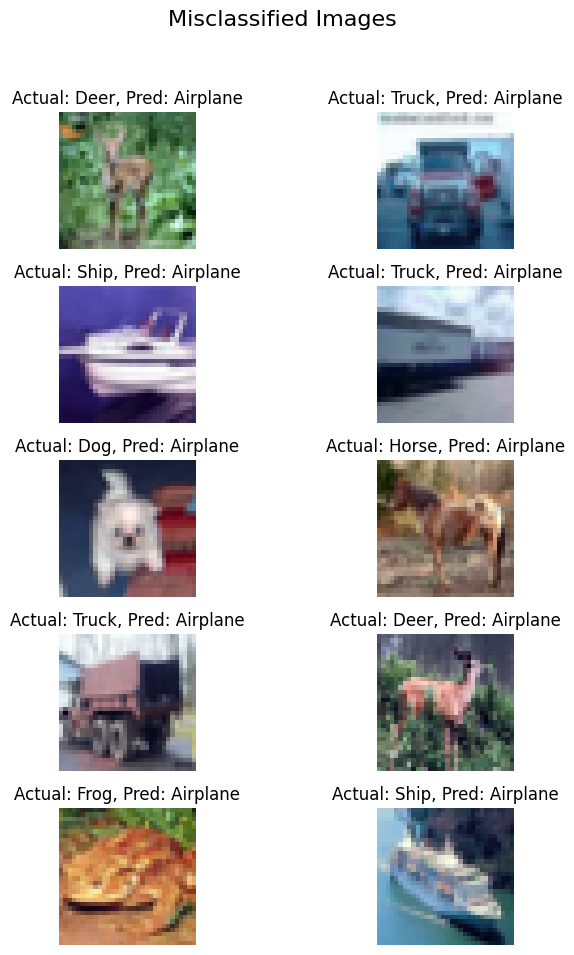

In [72]:
show_misclasses(failed_samples,"Misclassified Images ")

AttributeError: 'NoneType' object has no attribute 'cpu'

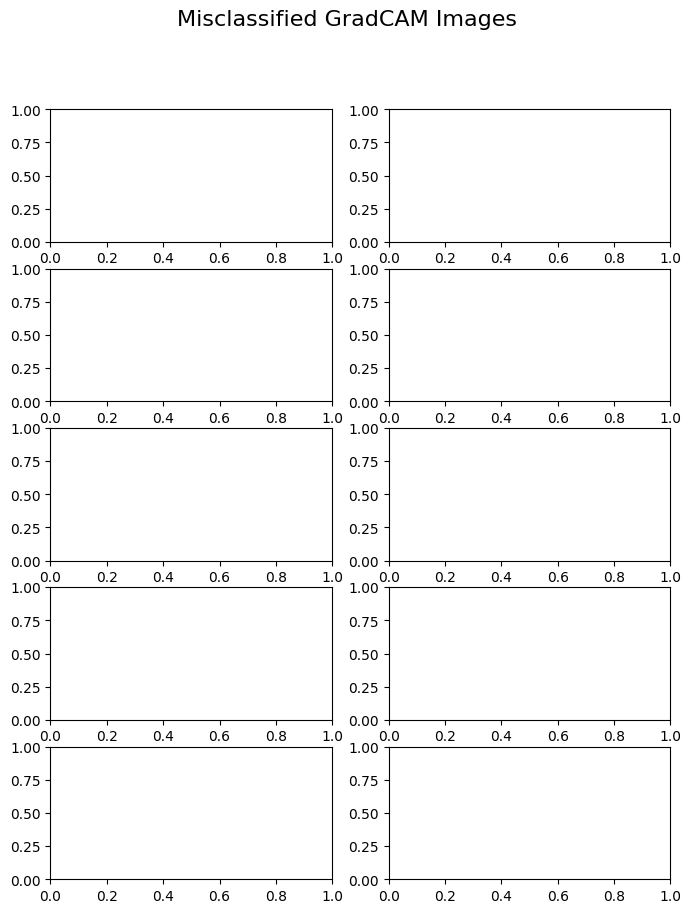

In [73]:
show_misclasses(grad_cam_samples,"Misclassified GradCAM Images ")